# Exercise 1 - Electron-Positron scattering

In [1]:
from pathlib import Path
from functools import partial
import itertools

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import tqdm.contrib.concurrent
import vegas

import integrate
import constants as const

## 1a)

Define constants and set the seed

See the implementation of the integrator in module `integrate` as `integrate_sampler`

In [2]:
DATA_DIR = Path("../data")
FIGURE_DIR = Path("../report/figures")
samples = 1_000
realizations = 10_000

m_z = const.Z_MASS
s = m_z**2
interval = [[-1, 1], [-const.pi, const.pi]]
volume_element = 2 * 2 * const.pi * const.NUM_LIGHT_QUARK_FLAV

np.random.seed(42)

real = 42_250

### Define the scattering matrix element

In [3]:
def scattering_mat(flav, s, costheta, _):
    """Scattering matrix element for given flavor and particle outcome."""
    quark_charge, quark_iso_spin = const.quark_info(flav)
    prefactor = (4 * const.pi * const.QED_COUPLING)**2 * const.NUM_QCD_COLORS

    kappa = 1 / 4 / const.WEINBERG_ANGLE_SQ_SINE / (
        1 - const.WEINBERG_ANGLE_SQ_SINE
    )
    chi_denom = (
        s - const.Z_MASS**2
    )**2 + const.Z_MASS**2 * const.Z_DECAY_WIDTH**2
    chi1 = kappa * s * (s - const.Z_MASS**2) / chi_denom
    chi2 = kappa**2 * s**2 / chi_denom

    a_elec = const.DOWN_QUARK_WEAK_ISOSPIN
    a_quark = quark_iso_spin
    v_elec = const.DOWN_QUARK_WEAK_ISOSPIN - 2 * const.ELECTRON_CHARGE * const.WEINBERG_ANGLE_SQ_SINE
    v_quark = quark_iso_spin - 2 * quark_charge * const.WEINBERG_ANGLE_SQ_SINE
    cos_pre = 4 * const.ELECTRON_CHARGE * quark_charge * a_elec * a_quark * chi1 \
        + 8 * a_elec * v_elec * a_quark * v_quark * chi2

    cos_sq_pre = const.ELECTRON_CHARGE ** 2 * quark_charge ** 2 \
        + 2 * const.ELECTRON_CHARGE * quark_charge * v_elec * v_quark * chi1 \
        + (a_elec ** 2 + v_elec ** 2) * (a_quark ** 2 + v_quark ** 2) * chi2

    val = costheta * cos_pre + (1 + costheta * costheta) * cos_sq_pre

    return prefactor * val

### Define different functions to calculate the differential cross section.

In [4]:
def diff_cross_sec_av(flavor, costheta_phi_array):
    """Used to calculate the differential cross section using the average method."""
    costheta, phi = costheta_phi_array[..., 0], costheta_phi_array[..., 1]
    flav = np.ones_like(costheta) * flavor
    scatt_amp = scattering_mat(flav, s, costheta, phi)
    return const.CONVERSION_FACTOR / (s * 64 * const.pi**2) * scatt_amp

def diff_cross_section(costheta_phi_flav_array):
    """Used to calculate the differential cross section with randomly sampled flavors."""
    costheta, phi, flav = costheta_phi_flav_array[..., 0], costheta_phi_flav_array[..., 1], costheta_phi_flav_array[..., 2]
    scatt_amp = scattering_mat(flav, s, costheta, phi)
    return const.CONVERSION_FACTOR / (s * 64 * const.pi**2) * scatt_amp

## 1b)
Compare both methods

In [5]:
def total_cross_section_av(_):
    result = []
    flavors = (1, 2, 3, 4, 5)
    for flavor in flavors:
        func = partial(diff_cross_sec_av, flavor)
        process = partial(integrate.uniform_sampler, interval=interval)
        val, _ = integrate.integrate_sampler(func, samples, sampler=process, volume_element=volume_element)
        result.append(val)
    return sum(result) / len(flavors)

def total_cross_section_rnd(_):
    quark_process = partial(
        integrate.quark_scattering_process, interval=interval
    )
    res, _ = integrate.integrate_sampler(
        diff_cross_section, samples, sampler=quark_process, volume_element=volume_element
    )
    return res

av_ens, rnd_ens = [], []
av_ens = tqdm.contrib.concurrent.process_map(
    total_cross_section_av, range(realizations), max_workers=3, chunksize=10
)
rnd_ens = tqdm.contrib.concurrent.process_map(
    total_cross_section_rnd, range(realizations), max_workers=3, chunksize=10
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Averaging method: mean=42211 std=167
Random sampling method: mean=42207 std=404


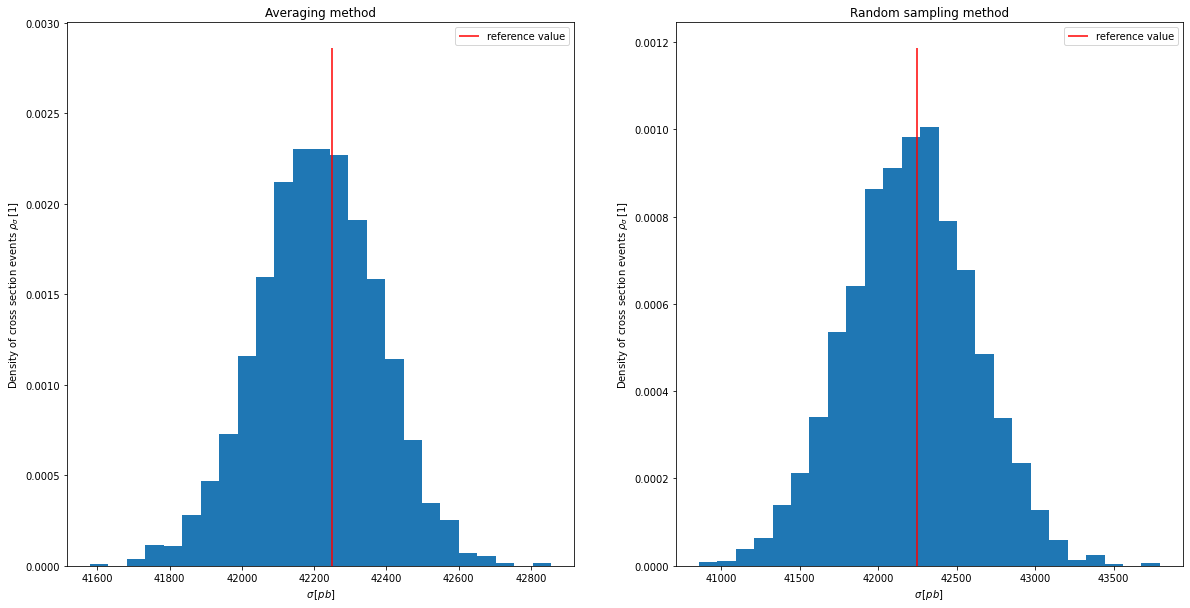

In [6]:
bins = 25
v_height = 1.2 / np.sqrt(2 * np.pi)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(av_ens, bins=bins, density=True, stacked=True)
ax1.set_title("Averaging method")
ax1.vlines(
    real, 0, v_height / np.std(av_ens), color="r", label="reference value"
)
ax1.set_ylabel("Density of cross section events $\\rho_\\sigma \\, [1]$")
ax1.set_xlabel("$\\sigma \\, [pb]$")
ax1.legend()
ax1_extend = ax1.get_window_extent().transformed(
    fig.dpi_scale_trans.inverted()
).expanded(1.3, 1.2)

ax2.hist(rnd_ens, bins=bins, density=True, stacked=True)
ax2.set_title("Random sampling method")
ax2.vlines(
    real, 0, v_height / np.std(rnd_ens), color="r", label="reference value"
)
ax2.set_ylabel("Density of cross section events $\\rho_\\sigma \\, [1]$")
ax2.set_xlabel("$\\sigma \\, [pb]$")
ax2.legend()
ax2_extend = ax2.get_window_extent().transformed(
    fig.dpi_scale_trans.inverted()
).expanded(1.3, 1.2)

print(f"Averaging method: mean={np.mean(av_ens):.0f} std={np.std(av_ens):.0f}")
print(
    f"Random sampling method: mean={np.mean(rnd_ens):.0f} std={np.std(rnd_ens):.0f}"
)

fig.savefig(FIGURE_DIR / "ex_1b_averaging_method.png", bbox_inches=ax1_extend)
fig.savefig(FIGURE_DIR / "ex_1b_random_sampling.png", bbox_inches=ax2_extend)
np.savetxt(DATA_DIR / "ex_1b_averaging_method.csv", av_ens)
np.savetxt(DATA_DIR / "ex_1b_random_sampling.csv", rnd_ens)

### Show the log-log plot and linear fit

In [7]:
samples_log = np.unique(np.logspace(1, 4, base=10, num=1000, dtype=np.int16))
quark_process = partial(integrate.quark_scattering_process, interval=interval)
errors = []
for n in samples_log:
    val, _ = integrate.integrate_sampler(diff_cross_section, n, quark_process, volume_element)
    errors.append(np.abs(val - real))

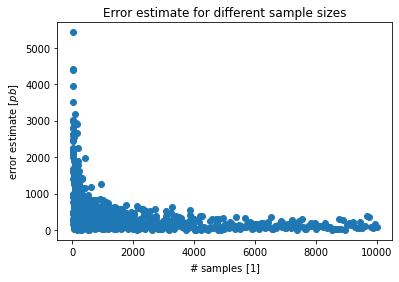

In [8]:
plt.scatter(samples_log, errors)
plt.ylabel("error estimate $[pb]$")
plt.xlabel("# samples $[1]$")
plt.title("Error estimate for different sample sizes")

plt.savefig(FIGURE_DIR / "ex_1b_error_vs_samples.png")
np.savetxt(DATA_DIR / "ex_1b_error_vs_samples.csv", np.c_[samples_log, errors])

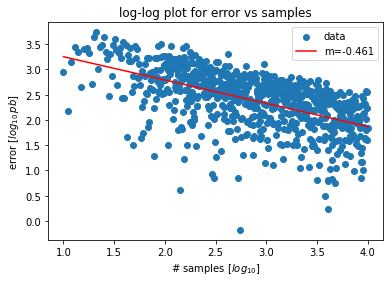

In [9]:
x_log, y_log = np.log10(samples_log), np.log10(errors)
plt.scatter(x_log, y_log, label="data")

regr = scipy.stats.linregress(x_log, y_log)
x = np.linspace(x_log.min(), x_log.max())
plt.plot(
    x,
    regr.slope * x + regr.intercept,  # type: ignore
    label=f"m={regr.slope:.3f}",  # type: ignore
    c="r"
)

plt.ylabel("error $[log_{10}\\,pb]$")
plt.xlabel("# samples $[log_{10}]$")
plt.title("log-log plot for error vs samples")
plt.legend()

plt.savefig(FIGURE_DIR / "ex_1b_error_vs_samples_loglog.png")
np.savetxt(DATA_DIR / "ex_1b_error_vs_samples_loglog.csv", np.c_[x_log, y_log])

## 1c)
We use native MPL instead of using the provided utils libraries

In [10]:
m_z, gamma_z = const.Z_MASS, const.Z_DECAY_WIDTH
samples = 10_000
realizations = 10_000

interval_s = [[(m_z - 3 * gamma_z)**2, (m_z + 3 * gamma_z)**2], *interval]

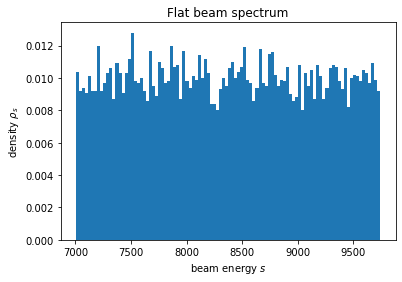

In [11]:
quark_process = partial(
    integrate.quark_scattering_process, interval=interval_s
)
mc_numbers = quark_process(samples)
s = mc_numbers[..., 0]
weights = np.ones_like(s) / samples

plt.hist(s, bins=100, weights=weights)
plt.ylabel("density $\\rho_s$")
plt.xlabel("beam energy $s$")
plt.title("Flat beam spectrum")

plt.savefig(FIGURE_DIR / "ex_1c_histogram_s.png")
np.savetxt(DATA_DIR / "ex_1c_histogram_s.csv", s)

## 1d)

In [12]:
def diff_cross_section_s(s_costheta_phi_flav_array):
    """Used to calculate the differential cross section, sampling both beam energy and flavors."""
    s, costheta , phi, flav = s_costheta_phi_flav_array[..., 0], s_costheta_phi_flav_array[..., 1], s_costheta_phi_flav_array[..., 2], s_costheta_phi_flav_array[..., 3]
    scatt_amp = scattering_mat(flav.astype(np.int16), s, costheta, phi)
    return const.CONVERSION_FACTOR / (s * 64 * const.pi**2) * scatt_amp

def total_cross_section_s(_):
    quark_process = partial(
        integrate.quark_scattering_process, interval=interval_s
    )
    res, _ = integrate.integrate_sampler(
        diff_cross_section_s, samples, sampler=quark_process, volume_element=volume_element
    )
    return res

s_ens = tqdm.contrib.concurrent.process_map(
    total_cross_section_s, range(realizations), max_workers=4, chunksize=10
)
np.mean(s_ens), np.std(s_ens)

  0%|          | 0/10000 [00:00<?, ?it/s]

(9930.099815293324, 124.0955420484668)

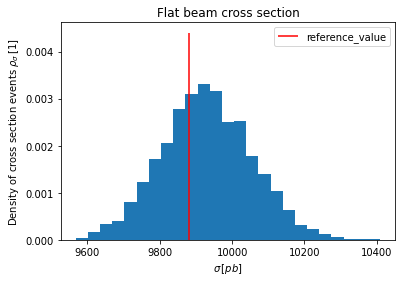

In [13]:
real_flat_beam = 9_880
bins = 25
v_height = .0044

plt.hist(s_ens, density=True, stacked=True, bins=25)
plt.vlines(real_flat_beam, 0, v_height, color="r", label="reference_value")
plt.ylabel("Density of cross section events $\\rho_\\sigma \\, [1]$")
plt.xlabel("$\\sigma \\, [pb]$")
plt.title("Flat beam cross section")
plt.legend()

plt.savefig(FIGURE_DIR / "ex_1c_flat_beam_hist.png")
np.savetxt(DATA_DIR / "ex_1c_flat_beam_hist.csv", s_ens)

### Show the log-log plot for the flat beam spectrum

In [14]:
samples_log = np.unique(np.logspace(1, 4, base=10, num=1000, dtype=np.int16))
s_quark_process = partial(
    integrate.quark_scattering_process, interval=interval_s
)
errors = []
for n in samples_log:
    val, _ = integrate.integrate_sampler(diff_cross_section_s, n, s_quark_process, volume_element)
    errors.append(np.abs(val - real_flat_beam))

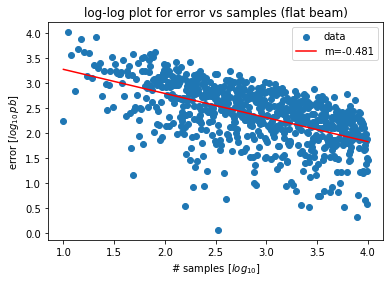

In [15]:
x_log, y_log = np.log10(samples_log), np.log10(errors)
plt.scatter(x_log, y_log, label="data")

regr = scipy.stats.linregress(x_log, y_log)
x = np.linspace(x_log.min(), x_log.max())
plt.plot(
    x,
    regr.slope * x + regr.intercept,  # type: ignore
    label=f"m={regr.slope:.3f}",  # type: ignore
    c="r"
)

plt.ylabel("error $[log_{10}\\,pb]$")
plt.xlabel("# samples $[log_{10}]$")
plt.title("log-log plot for error vs samples (flat beam)")
plt.legend()

plt.savefig(FIGURE_DIR / "ex_1c_error_vs_samples_loglog.png")
np.savetxt(DATA_DIR / "ex_1c_error_vs_samples_loglog.csv", np.c_[x_log, y_log])

### Show the spectrum with respect to s

Text(0, 0.5, '$\\frac{\\partial \\sigma}{\\partial X}$')

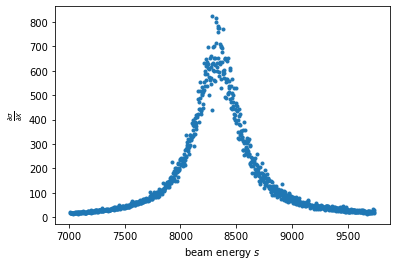

In [16]:
space_num = 1_000
mc_numbers = s_quark_process(samples)
func_vals = diff_cross_section_s(mc_numbers)

s_space = np.linspace(interval_s[0][0], interval_s[0][1], num=space_num)
bin_idx = np.digitize(mc_numbers[..., 0], s_space)
bin_to_vals = np.c_[bin_idx, func_vals]
val_count, counts = np.unique(bin_to_vals[:, 0], return_counts=True)
hist = np.zeros(space_num - 1)
for bin, val in bin_to_vals:
    hist[int(bin) - 1] += val

bin_middle = (s_space[1:] - s_space[:-1]) / 2 + s_space[:-1]

plt.scatter(bin_middle, hist / counts, marker=".")
plt.xlabel("beam energy $s$")
plt.ylabel("$\\frac{\\partial \\sigma}{\\partial X}$")

Text(0, 0.5, '$\\sigma$')

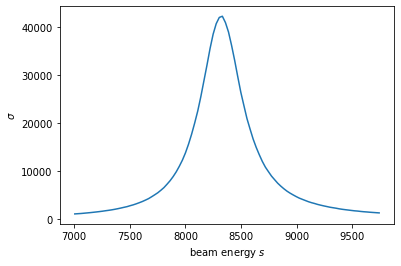

In [17]:
s_space = np.linspace(interval_s[0][0], interval_s[0][1], num=100)

res = []
for s in s_space:
    res.append(total_cross_section_rnd(None))

plt.plot(s_space, res)
plt.xlabel("beam energy $s$")
plt.ylabel("$\\sigma$")

## 1e) Use `vegas` package

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.827(90)e+07   2.827(90)e+07       0.00     1.00
  2   2.706(43)e+07   2.729(39)e+07       1.46     0.23
  3   2.749(33)e+07   2.741(25)e+07       0.81     0.44
  4   2.693(24)e+07   2.715(17)e+07       1.17     0.32
  5   2.709(20)e+07   2.713(13)e+07       0.89     0.47
  6   2.721(18)e+07   2.716(11)e+07       0.74     0.59
  7   2.735(15)e+07   2.7222(86)e+07      0.81     0.56
  8   2.726(12)e+07   2.7235(70)e+07      0.70     0.67
  9   2.701(11)e+07   2.7167(58)e+07      1.01     0.43
 10   2.7195(89)e+07  2.7176(49)e+07      0.90     0.52



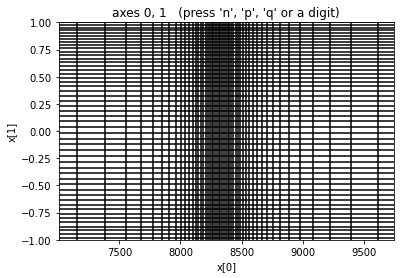

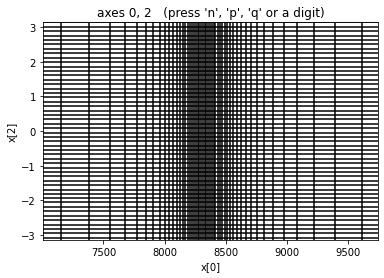

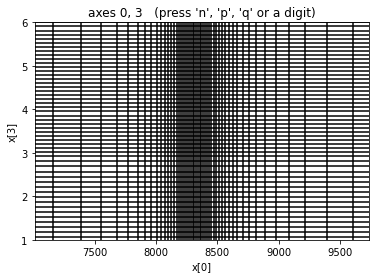

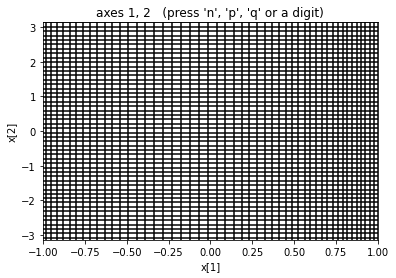

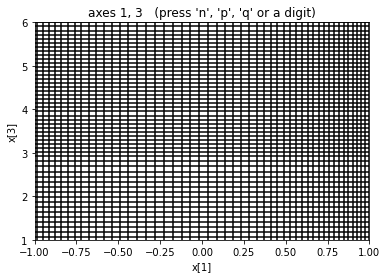

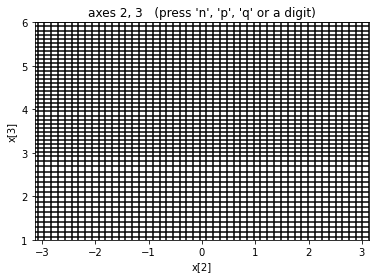

<Figure size 432x288 with 0 Axes>

In [18]:
integr = vegas.Integrator(list(interval_s) + [[1, 6]])
res = integr(diff_cross_section_s, nitn=10, neval=1_000)
print(res.summary())
for pair in list(itertools.combinations(range(4), 2)):
    integr.map.show_grid(axes=[pair])

plt.savefig(FIGURE_DIR / "ex_1e_grids.png")

## 1f)

In [19]:
rho_min = np.arctan((interval_s[0][0] - m_z**2) / m_z / gamma_z)
rho_max = np.arctan((interval_s[0][1] - m_z**2) / m_z / gamma_z)
interval_rho = [[rho_min, rho_max]] + list(interval)
importance_sampler = partial(
    integrate.importance_quark_scattering,
    interval=interval_rho,
    mass=m_z,
    gamma=gamma_z
)
integrate.integrate_sampler(
    diff_cross_section_s,
    samples,
    importance_sampler,
    volume_element,
    realizations=100
)

(23552.331657146937, 180.0379415469018)